In [1]:
# COMPLETAR OS DADOS METEROLÓGICOS DOS PEFIS DE PRESSÃO

In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import os

In [3]:
xr.set_options(display_max_rows=50, display_width=150)

In [4]:
time_list = pd.read_csv(r"..\..\Data\Interim\Meteorological_data\time_list.csv")["datetime"].apply(pd.to_datetime).tolist()

date_list = [t.date() for t in time_list]
date_list = np.array(date_list, dtype='datetime64[D]')
print(date_list[:5])

['2015-08-03' '2015-08-03' '2015-08-03' '2015-08-03' '2015-08-03']


In [5]:
shp = gpd.read_file(r"../../Data/Interim/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireSprd_v2.1_L2_valid.shp")
shp = shp.to_crs("EPSG:4326")

In [6]:
ds_SL = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_SL.nc")
ds_PL = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_PL.nc") 
ds_Land = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_Land.nc") 
ds_GP = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_GP.nc")  
ds_Fb = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_Fb.nc") 
ds_FWI = xr.open_dataset("../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_FWI.nc") 

ds_SL = ds_SL.sel(valid_time=[t for t in time_list if t in ds_SL.valid_time.values])
ds_PL = ds_PL.sel(valid_time=[t for t in time_list if t in ds_PL.valid_time.values])
ds_Land = ds_Land.sel(valid_time=[t for t in time_list if t in ds_Land.valid_time.values])
ds_Fb = ds_Fb.sel(valid_time=[t for t in time_list if t in ds_Fb.valid_time.values])

print(ds_SL, ds_PL, ds_Land, ds_GP, ds_Fb, ds_FWI)

<xarray.Dataset> Size: 59MB
Dimensions:     (valid_time: 2486, latitude: 25, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 200B 43.0 42.75 42.5 42.25 42.0 41.75 41.5 41.25 41.0 40.75 ... 39.0 38.75 38.5 38.25 38.0 37.75 37.5 37.25 37.0
  * longitude   (longitude) float64 136B -10.0 -9.75 -9.5 -9.25 -9.0 -8.75 -8.5 -8.25 -8.0 -7.75 -7.5 -7.25 -7.0 -6.75 -6.5 -6.25 -6.0
Data variables:
    u100        (valid_time, latitude, longitude) float32 4MB ...
    v100        (valid_time, latitude, longitude) float32 4MB ...
    cbh         (valid_time, latitude, longitude) float32 4MB ...
    hcc         (valid_time, latitude, longitude) float32 4MB ...
    lcc         (valid_time, latitude, longitude) float32 4MB ...
    mcc         (valid_time, latitude, longitude) float32 4MB ...
    tcc         (valid_time, latitude, longitude) float32 4MB ...
 

In [7]:
# Unir ds_Land a ds_GP

ds_GP = ds_GP.isel(time=0).drop_vars("time", errors="ignore")

ds_GP = ds_GP.expand_dims({"valid_time": ds_Land.valid_time})

ds_GP = ds_GP.reindex_like(ds_Land, method='nearest')

ds_Land = xr.merge([ds_Land, ds_GP], join="exact")

ds_Land = ds_Land.drop_vars(["expver", "number"], errors="ignore")

print(ds_Land)

ds_GP.close()

<xarray.Dataset> Size: 149MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB ...
    t2m         (valid_time, latitude, longitude) float32 25MB ...
    u10         (valid_time, latitude, longitude) float32 25MB ...
    v10         (valid_time, latitude, longitude) float32 25MB ...
    sp          (valid_time, latitude, longitude) float32 25MB ...
    z           (valid_time, latitude, longitude) float32 25MB 11.48 -14.64 -12.63 1.433 -2.585 -58.84 ... 41.

In [8]:
# Unir o ds_SL ao ds_Land

ds_SL = ds_SL.interp(
    latitude=ds_Land.latitude,
    longitude=ds_Land.longitude,
    method="linear"
)

ds_SL = xr.merge([ds_Land, ds_SL], join="right")
print(ds_SL)

<xarray.Dataset> Size: 846MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB ...
    t2m         (valid_time, latitude, longitude) float32 25MB ...
    u10         (valid_time, latitude, longitude) float32 25MB ...
    v10         (valid_time, latitude, longitude) float32 25MB ...
    sp          (valid_time, latitude, longitude) float32 25MB ...
    z           (valid_time, latitude, longitude) float32 25MB 11.48 -14.64 -12.63 1.433 -2.585 -58.84 ... 41.

In [9]:
ds_SL = ds_SL.chunk({"valid_time": 100})
ds_Fb = ds_Fb.chunk({"valid_time": 100})


ds_Fb = ds_Fb.interp(
    latitude=ds_SL.latitude,
    longitude=ds_SL.longitude,
    method="linear"
)

print("Boa")

# Depois preenche missing com ds_Fb
ds_SL, ds_Fb = xr.align(ds_SL, ds_Fb, join="left")

ds_SL = ds_SL.combine_first(ds_Fb)

print(ds_SL)

Boa
<xarray.Dataset> Size: 846MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61,

In [10]:
ds_Fb = ds_Fb.rename({
    't2m': 't2m_Fb', 
    'd2m': 'd2m_Fb',
    'u10': 'u10_Fb',
    'v10': 'v10_Fb',
    'sp': 'sp_Fb',})

ds_SL= xr.merge([ds_SL, ds_Fb])

print(ds_SL)

<xarray.Dataset> Size: 970MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41)

In [11]:
print(ds_FWI)

<xarray.Dataset> Size: 712kB
Dimensions:     (valid_time: 202, values: 291)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2015-08-03 2015-08-04 2015-08-08 2015-08-09 2015-08-10 ... 2025-08-20 2025-08-21 2025-08-22 2025-08-23
    latitude    (values) float64 2kB ...
    longitude   (values) float64 2kB ...
Dimensions without coordinates: values
Data variables:
    drtcode     (valid_time, values) float32 235kB ...
    ffmcode     (valid_time, values) float32 235kB ...
    fwinx       (valid_time, values) float32 235kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-17T18:00 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.42.0 with {"source": "tmprg2hvhn5/data.grib", "filter_by...


Primeira data: 2015-08-03T00:00:00.000000000
Primeira variável: drtcode

Dimensões do dataset: FrozenMappingWarningOnValuesAccess({'valid_time': 202, 'values': 291})
Coordenadas disponíveis: ['latitude', 'longitude', 'valid_time']


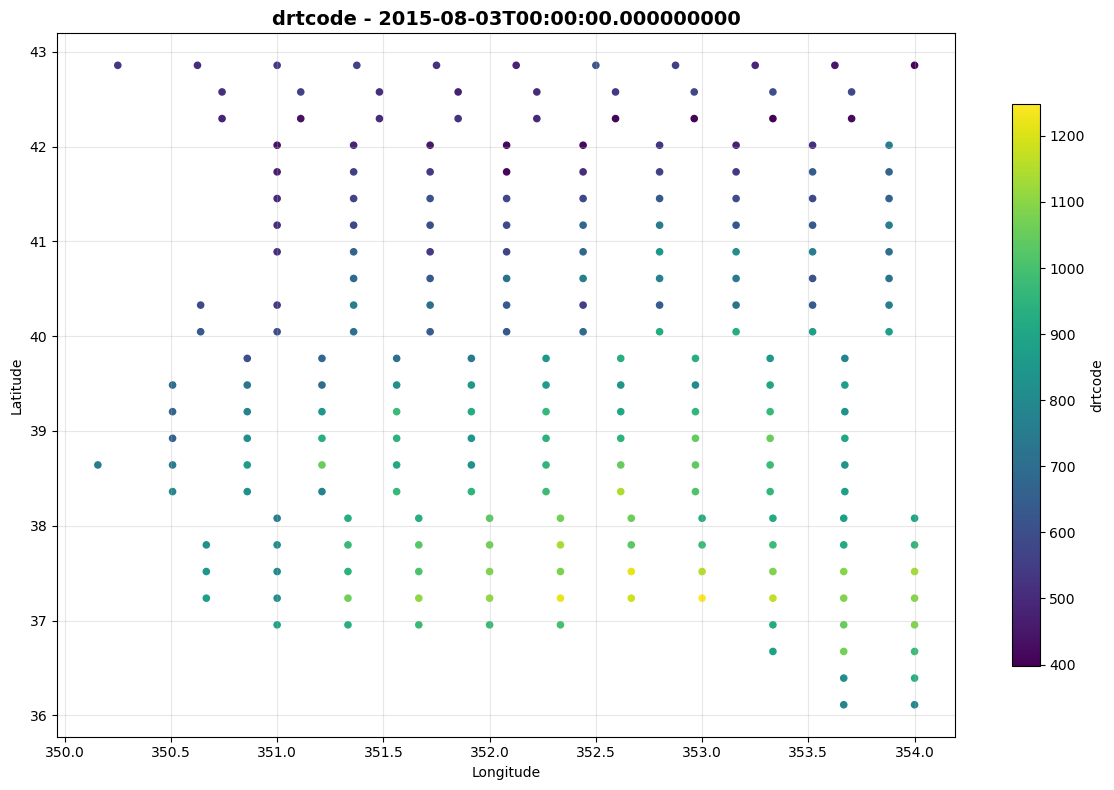


Estatísticas dos dados:
Valor mínimo: 397.25
Valor máximo: 1248.75
Valor médio: 775.28
Valores NaN: 71


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionar a primeira data e primeira variável
first_date = ds_FWI.valid_time[0].values
first_var = list(ds_FWI.data_vars.keys())[0]

print(f"Primeira data: {first_date}")
print(f"Primeira variável: {first_var}")

# Verificar a estrutura dos dados
print(f"\nDimensões do dataset: {ds_FWI.dims}")
print(f"Coordenadas disponíveis: {list(ds_FWI.coords.keys())}")

# Plotar usando scatter plot já que os dados estão em formato de pontos
fig, ax = plt.subplots(figsize=(12, 8))

# Obter os dados para a primeira data
plot_data = ds_FWI[first_var].isel(valid_time=0)

# Criar scatter plot com cores baseadas nos valores
scatter = ax.scatter(ds_FWI.longitude, ds_FWI.latitude, 
                     c=plot_data, cmap='viridis', s=20)

# Adicionar barra de cores
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label(f'{first_var}')

# Configurar título e labels
ax.set_title(f'{first_var} - {first_date}', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adicionar grid
ax.grid(True, alpha=0.3)

# Mostrar o plot
plt.tight_layout()
plt.show()

# Informações adicionais sobre os dados
print(f"\nEstatísticas dos dados:")
print(f"Valor mínimo: {plot_data.min().values:.2f}")
print(f"Valor máximo: {plot_data.max().values:.2f}")
print(f"Valor médio: {plot_data.mean().values:.2f}")
print(f"Valores NaN: {np.isnan(plot_data).sum().values}")

In [13]:
# Máscara super simples para Portugal - CORRIGIDA
lat = ds_FWI.latitude.values
lon = ds_FWI.longitude.values

# Portugal continental no sistema 0-360°
# -9.5°W = 350.5°E, -6°W = 354°E
mask_portugal = (lat >= 35) & (lat <= 45) & (lon >= 345) & (lon <= 360)

# Aplicar a máscara
ds_FWI = ds_FWI.isel(values=mask_portugal)

# Agrupar por data e calcular média - CORREÇÃO
ds_FWI = ds_FWI.groupby('valid_time').mean()

print(ds_FWI)

<xarray.Dataset> Size: 712kB
Dimensions:     (valid_time: 202, values: 291)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2015-08-03 2015-08-04 2015-08-08 2015-08-09 2015-08-10 ... 2025-08-20 2025-08-21 2025-08-22 2025-08-23
    latitude    (values) float64 2kB 42.86 42.86 42.86 42.86 42.86 42.86 42.86 42.86 42.86 ... 36.11 36.11 36.11 36.11 36.11 36.11 36.11 36.11 36.11
    longitude   (values) float64 2kB 350.2 350.6 351.0 351.4 351.8 352.1 352.5 352.9 353.2 ... 351.3 351.7 352.0 352.3 352.7 353.0 353.3 353.7 354.0
Dimensions without coordinates: values
Data variables:
    drtcode     (valid_time, values) float32 235kB 532.2 505.5 537.8 566.8 517.8 478.0 618.8 554.0 487.5 ... nan nan nan nan nan nan nan 860.2 818.5
    ffmcode     (valid_time, values) float32 235kB 74.6 74.32 83.25 86.27 85.2 85.99 88.68 89.32 90.84 ... nan nan nan nan nan nan nan 79.45 80.27
    fwinx       (valid_time, values) float32 235kB 5.25 1.574 11.91 19.74 18.34 18.13 23.98 21.37 23.54 ... nan

Primeira data: 2015-08-03T00:00:00.000000000
Primeira variável: drtcode

Dimensões do dataset: FrozenMappingWarningOnValuesAccess({'valid_time': 202, 'values': 291})
Coordenadas disponíveis: ['latitude', 'longitude', 'valid_time']


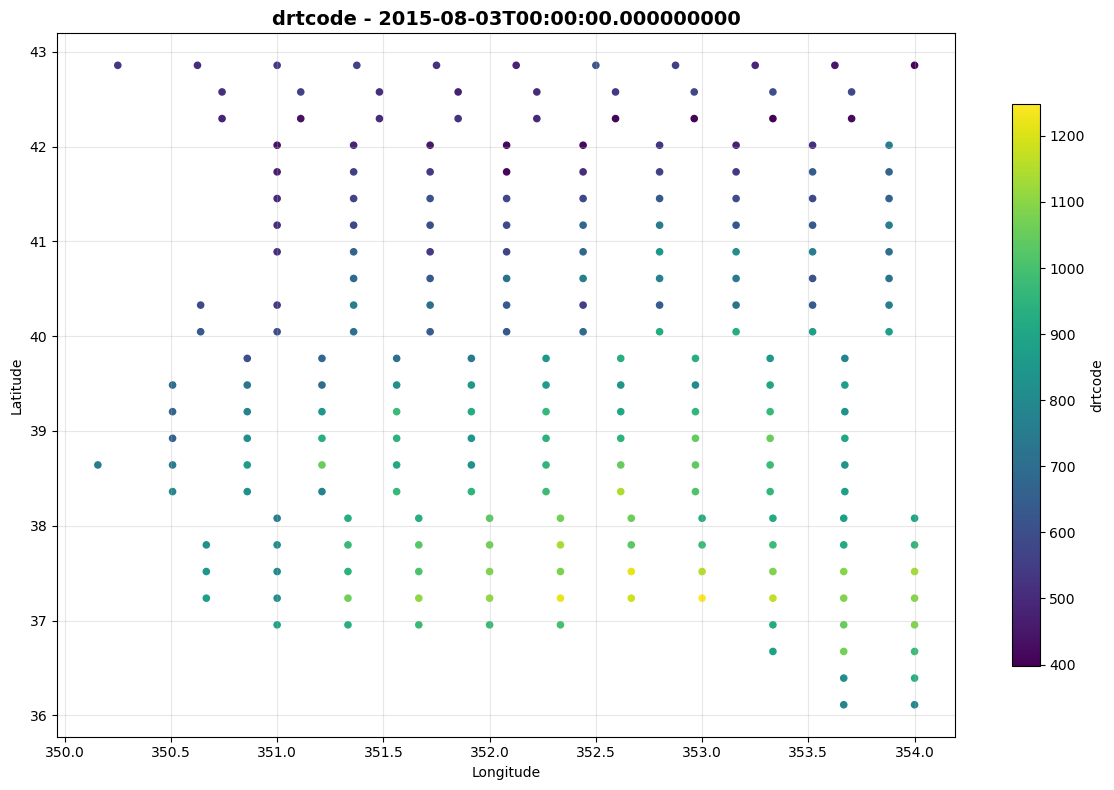


Estatísticas dos dados:
Valor mínimo: 397.25
Valor máximo: 1248.75
Valor médio: 775.28
Valores NaN: 71


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionar a primeira data e primeira variável
first_date = ds_FWI.valid_time[0].values
first_var = list(ds_FWI.data_vars.keys())[0]

print(f"Primeira data: {first_date}")
print(f"Primeira variável: {first_var}")

# Verificar a estrutura dos dados
print(f"\nDimensões do dataset: {ds_FWI.dims}")
print(f"Coordenadas disponíveis: {list(ds_FWI.coords.keys())}")

# Plotar usando scatter plot já que os dados estão em formato de pontos
fig, ax = plt.subplots(figsize=(12, 8))

# Obter os dados para a primeira data
plot_data = ds_FWI[first_var].isel(valid_time=0)

# Criar scatter plot com cores baseadas nos valores
scatter = ax.scatter(ds_FWI.longitude, ds_FWI.latitude, 
                     c=plot_data, cmap='viridis', s=20)

# Adicionar barra de cores
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label(f'{first_var}')

# Configurar título e labels
ax.set_title(f'{first_var} - {first_date}', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adicionar grid
ax.grid(True, alpha=0.3)

# Mostrar o plot
plt.tight_layout()
plt.show()

# Informações adicionais sobre os dados
print(f"\nEstatísticas dos dados:")
print(f"Valor mínimo: {plot_data.min().values:.2f}")
print(f"Valor máximo: {plot_data.max().values:.2f}")
print(f"Valor médio: {plot_data.mean().values:.2f}")
print(f"Valores NaN: {np.isnan(plot_data).sum().values}")

In [15]:
# 1. Converter longitude de 0-360° para -180° a 180°
ds_FWI = ds_FWI.assign_coords(longitude=(((ds_FWI.longitude + 180) % 360) - 180))

# 2. Redimensionar para ter latitude e longitude como dimensões coordenadas
ds_FWI = ds_FWI.set_index(values=('latitude', 'longitude')).unstack('values')

# 3. Criar dataset com todas as horas para cada dia
# Primeiro crie um dataset com a resolução horária
times_hourly = pd.date_range(start=ds_FWI.valid_time.min().values,
                            end=ds_FWI.valid_time.max().values + pd.Timedelta(hours=23),
                            freq='H')

# Interpolar para todas as horas mantendo o mesmo valor para todo o dia
ds_FWI = ds_FWI.reindex(valid_time=times_hourly, method='ffill')

print(ds_FWI)

C:\Users\Rafael Oliveira\AppData\Local\Temp\1\ipykernel_15436\2349447428.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times_hourly = pd.date_range(start=ds_FWI.valid_time.min().values,


<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 88176, latitude: 25, longitude: 52)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 705kB 2015-08-03 2015-08-03T01:00:00 2015-08-03T02:00:00 ... 2025-08-23T22:00:00 2025-08-23T23:00:00
  * latitude    (latitude) float64 200B 36.11 36.39 36.67 36.96 37.24 37.52 37.8 38.08 38.36 ... 40.61 40.89 41.17 41.45 41.73 42.01 42.3 42.58 42.86
  * longitude   (longitude) float64 416B -10.0 -9.844 -9.75 -9.72 -9.667 -9.63 -9.492 -9.375 ... -6.667 -6.48 -6.375 -6.333 -6.328 -6.296 -6.12 -6.0
Data variables:
    drtcode     (valid_time, latitude, longitude) float32 459MB nan nan nan nan nan nan nan nan nan nan ... nan nan nan 651.0 nan nan nan nan 589.0
    ffmcode     (valid_time, latitude, longitude) float32 459MB nan nan nan nan nan nan nan nan nan nan ... nan nan nan 91.55 nan nan nan nan 90.07
    fwinx       (valid_time, latitude, longitude) float32 459MB nan nan nan nan nan nan nan nan nan nan ... nan nan nan 33.68 nan nan nan n

Primeira data: 2015-08-03T00:00:00.000000000
Primeira variável: drtcode
Shape dos dados: (25, 52)
Dimensões: ('latitude', 'longitude')


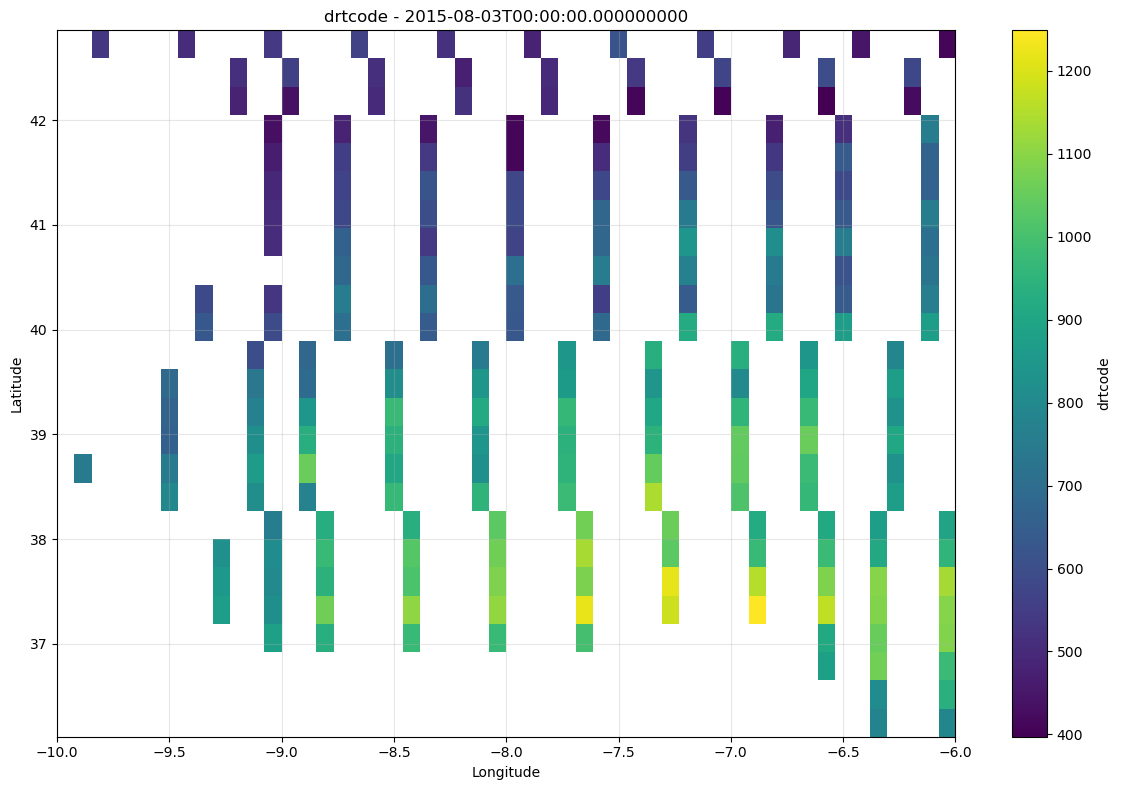

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionar a primeira data e primeira variável
first_date = ds_FWI.valid_time[0].values
first_var = list(ds_FWI.data_vars.keys())[0]

print(f"Primeira data: {first_date}")
print(f"Primeira variável: {first_var}")

# Obter os dados
plot_data = ds_FWI[first_var].isel(valid_time=0)

print(f"Shape dos dados: {plot_data.shape}")
print(f"Dimensões: {plot_data.dims}")

# MÉTODO CORRETO para grade regular
fig, ax = plt.subplots(figsize=(12, 8))

# Usar imshow com extent - FUNCIONA SEMPRE para grades regulares
im = ax.imshow(plot_data.values,
               extent=[ds_FWI.longitude.min(), ds_FWI.longitude.max(), 
                       ds_FWI.latitude.min(), ds_FWI.latitude.max()],
               origin='lower',
               cmap='viridis',
               aspect='auto')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(first_var)
ax.set_title(f'{first_var} - {first_date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
from scipy.interpolate import griddata
import numpy as np
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, as_completed  # <--- para paralelização

def interpolate_2d_array(data_array):
    """Interpolação 2D para um DataArray com dimensões (latitude, longitude)"""
    
    # Criar grade de coordenadas
    lon_grid, lat_grid = np.meshgrid(data_array.longitude, data_array.latitude)
    
    # Pontos com valores válidos
    valid_mask = ~np.isnan(data_array.values)
    points_valid = np.column_stack([lat_grid[valid_mask], lon_grid[valid_mask]])
    values_valid = data_array.values[valid_mask]
    
    # Pontos onde queremos interpolar
    points_target = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])
    
    # Interpolação 2D
    if len(values_valid) > 3:  # Precisa de pelo menos 3 pontos para interpolar
        interpolated = griddata(points_valid, values_valid, points_target, 
                               method='linear', fill_value=0)
    else:
        interpolated = np.zeros_like(data_array.values.ravel())
    
    return interpolated.reshape(data_array.shape)


# Função auxiliar para processar uma fatia temporal
def process_time_slice(var_data, i):
    slice_2d = var_data.isel(valid_time=i)
    return interpolate_2d_array(slice_2d)


# Aplicar a cada variável e cada tempo com paralelização
print("Aplicando interpolação 2D com paralelização...")
data_vars_interp = {}

for var in ds_FWI.data_vars:
    print(f"Processando {var}...")
    var_data = ds_FWI[var]
    
    interp_results = []
    
    # Paralelizar por fatia temporal
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_time_slice, var_data, i) 
                   for i in range(len(var_data.valid_time))]
        for future in as_completed(futures):
            interp_results.append(future.result())
    
    # Ordenar os resultados de volta pelo índice de tempo
    interp_results = [None]*len(var_data.valid_time)
    for i, future in enumerate(futures):
        interp_results[i] = future.result()
    
    # Criar DataArray interpolado
    data_vars_interp[var] = xr.DataArray(
        np.array(interp_results),
        dims=['valid_time', 'latitude', 'longitude'],
        coords={
            'valid_time': ds_FWI.valid_time,
            'latitude': ds_FWI.latitude,
            'longitude': ds_FWI.longitude
        },
        name=var
    )

ds_FWI = xr.Dataset(data_vars_interp)
ds_FWI = ds_FWI.where(ds_FWI != 0)
print("Interpolação 2D concluída!")


Aplicando interpolação 2D com paralelização...
Processando drtcode...


Processando ffmcode...
Processando fwinx...
Interpolação 2D concluída!


Primeira data: 2015-08-03T00:00:00.000000000
Primeira variável: drtcode
Shape dos dados: (25, 52)
Dimensões: ('latitude', 'longitude')


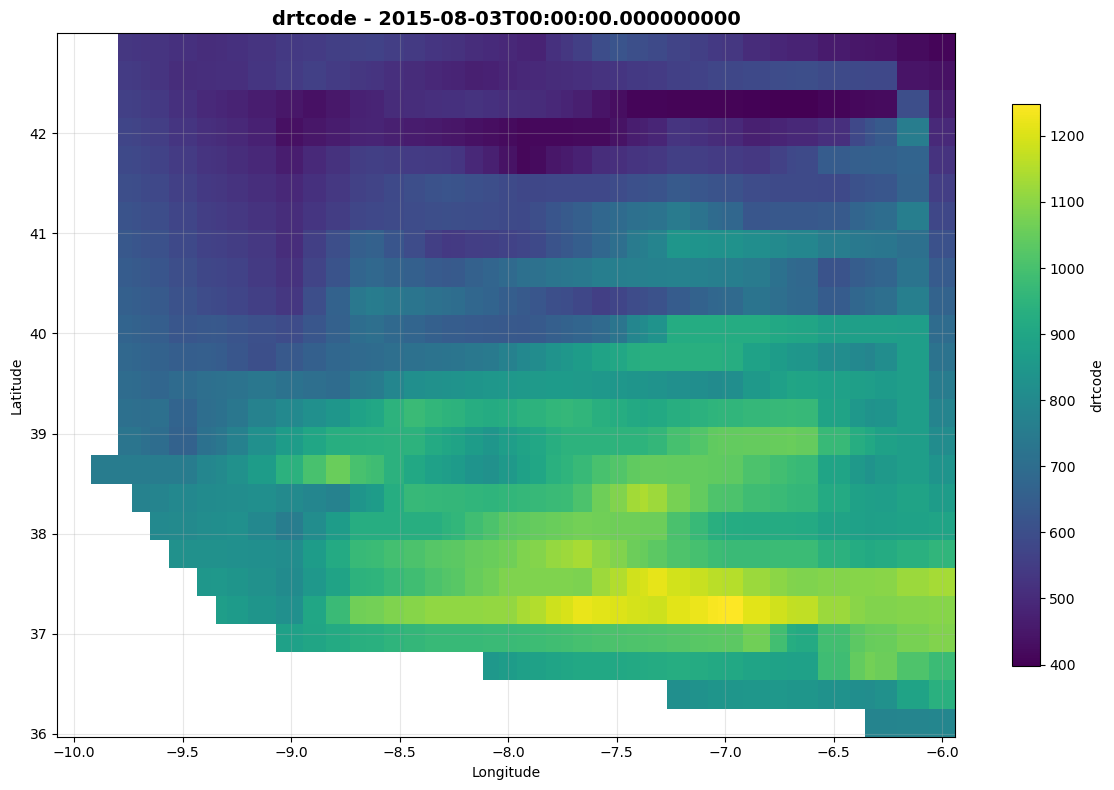


Estatísticas dos dados:
Valor mínimo: 397.25
Valor máximo: 1248.75
Valor médio: 759.00
Valores NaN: 180


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionar a primeira data e primeira variável
first_date = ds_FWI.valid_time[0].values
first_var = list(ds_FWI.data_vars.keys())[0]

print(f"Primeira data: {first_date}")
print(f"Primeira variável: {first_var}")

# Obter os dados
plot_data = ds_FWI[first_var].isel(valid_time=0)

print(f"Shape dos dados: {plot_data.shape}")
print(f"Dimensões: {plot_data.dims}")

# Criar o plot
fig, ax = plt.subplots(figsize=(12, 8))

# USAR PCOLORMESH - mantém orientação geográfica correta
im = ax.pcolormesh(ds_FWI.longitude, ds_FWI.latitude, plot_data,
                   cmap='viridis', shading='auto')

# Adicionar barra de cores
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label(first_var)

# Configurar título e labels
ax.set_title(f'{first_var} - {first_date}', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adicionar grid
ax.grid(True, alpha=0.3)

# Mostrar o plot
plt.tight_layout()
plt.show()

# Informações sobre os dados
print(f"\nEstatísticas dos dados:")
print(f"Valor mínimo: {plot_data.min().values:.2f}")
print(f"Valor máximo: {plot_data.max().values:.2f}")
print(f"Valor médio: {plot_data.mean().values:.2f}")
print(f"Valores NaN: {np.isnan(plot_data).sum().values}")

In [19]:
ds_FWI = ds_FWI.interp(
    latitude=ds_SL.latitude,
    longitude=ds_SL.longitude,
    method="linear"
)

Primeira data: 2015-08-03T00:00:00.000000000
Primeira variável: drtcode
Shape dos dados: (61, 41)
Dimensões: ('latitude', 'longitude')


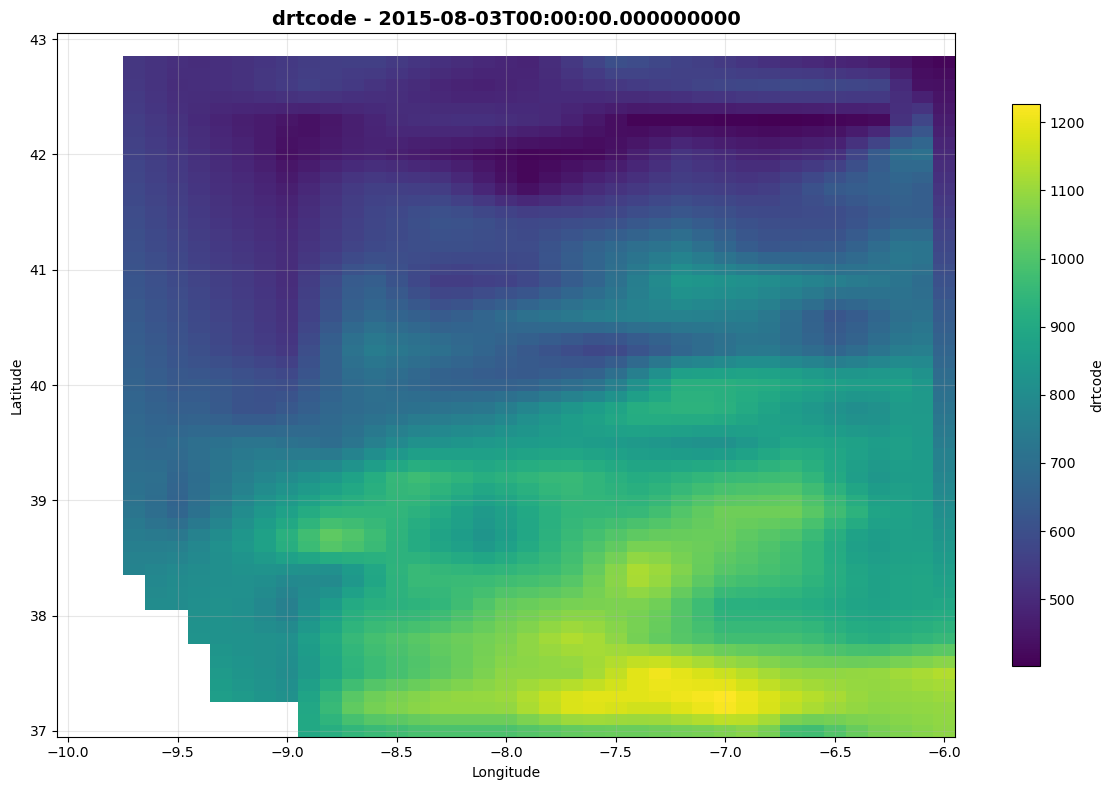


Estatísticas dos dados:
Valor mínimo: 401.41
Valor máximo: 1227.40
Valor médio: 753.37
Valores NaN: 315


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionar a primeira data e primeira variável
first_date = ds_FWI.valid_time[0].values
first_var = list(ds_FWI.data_vars.keys())[0]

print(f"Primeira data: {first_date}")
print(f"Primeira variável: {first_var}")

# Obter os dados
plot_data = ds_FWI[first_var].isel(valid_time=0)

print(f"Shape dos dados: {plot_data.shape}")
print(f"Dimensões: {plot_data.dims}")

# Criar o plot
fig, ax = plt.subplots(figsize=(12, 8))

# USAR PCOLORMESH - mantém orientação geográfica correta
im = ax.pcolormesh(ds_FWI.longitude, ds_FWI.latitude, plot_data,
                   cmap='viridis', shading='auto')

# Adicionar barra de cores
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label(first_var)

# Configurar título e labels
ax.set_title(f'{first_var} - {first_date}', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adicionar grid
ax.grid(True, alpha=0.3)

# Mostrar o plot
plt.tight_layout()
plt.show()

# Informações sobre os dados
print(f"\nEstatísticas dos dados:")
print(f"Valor mínimo: {plot_data.min().values:.2f}")
print(f"Valor máximo: {plot_data.max().values:.2f}")
print(f"Valor médio: {plot_data.mean().values:.2f}")
print(f"Valores NaN: {np.isnan(plot_data).sum().values}")

In [21]:
# 4. Agora fazer o merge com o ds_SL
ds_SL = xr.merge([ds_SL, ds_FWI], join='left')

print("Dataset FWI integrado com sucesso!")
print(ds_SL)

Dataset FWI integrado com sucesso!
<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 25MB d

In [22]:
ds_PL = ds_PL.chunk({"valid_time": 100})

ds_PL = ds_PL.interp(
    latitude=ds_SL.latitude, 
    longitude=ds_SL.longitude,
    method='linear'
)

print(ds_PL)

<xarray.Dataset> Size: 746MB
Dimensions:         (valid_time: 2486, pressure_level: 5, latitude: 61, longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * pressure_level  (pressure_level) float64 40B 950.0 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude       (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 124MB dask.array<chunksize=(100, 5, 61, 41), meta=np.ndarray>
    r               (valid_time, pressure_level, latitude, longitude) float32 124MB dask.array<chunksize=(100, 5, 61, 41), meta=np.ndarray>
    t               (valid_time, pressure_level, latitude, lo

In [23]:
# Garantir CRS
ds_SL = ds_SL.rio.write_crs("EPSG:4326", inplace=True)
ds_PL = ds_PL.rio.write_crs("EPSG:4326", inplace=True)
shp = shp.to_crs("EPSG:4326")


ds_SL = ds_SL.sel(valid_time=[t for t in time_list if t in ds_SL.valid_time.values])
ds_PL = ds_PL.sel(valid_time=[t for t in time_list if t in ds_PL.valid_time.values])

In [24]:
print (ds_SL)
print (ds_PL)

<xarray.Dataset> Size: 1GB
Dimensions:      (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude     (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude    (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
    spatial_ref  int64 8B 0
Data variables:
    d2m          (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(100, 61, 41), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 25MB dask.

In [26]:
import os
import dask
import xarray as xr

# Caminho de saída
out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_SL_c.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Computar Single Levels com chunks e paralelização automática do Dask
print("Computando Single Levels com paralelização...")
ds_SL = ds_SL.chunk({"valid_time": 100, "latitude": 20, "longitude": 20})

# Forçar computação paralela de todos os chunks
ds_SL = ds_SL.compute(scheduler='processes')  # threads paralelizam CPU-bound leve e I/O-bound
# Para mais paralelismo pesado, pode usar scheduler='processes'

# Encoding com compressão
encoding = {
    var: {
        'zlib': True,
        'complevel': 4,  # Compressão média
        'chunksizes': (100, 10, 10)
    } for var in ds_SL.data_vars
}

# Encoding específico para coordenadas
encoding['valid_time'] = {'dtype': 'int64'}
encoding['latitude'] = {'dtype': 'float32'}
encoding['longitude'] = {'dtype': 'float32'}

# Salvar NetCDF
ds_SL.to_netcdf(out_path, encoding=encoding)
print("✅ NetCDF Single Levels consolidado guardado")


Computando Single Levels com paralelização...
✅ NetCDF Single Levels consolidado guardado


In [28]:
import os
import xarray as xr

# ⚡ Chunking para paralelização
ds_PL = ds_PL.chunk({"valid_time": 100, "latitude": 20, "longitude": 20, "pressure_level": 5})

# Caminho de saída
out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_PL_c.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# ⚡ Computar todos os chunks em paralelo usando processos
print("Computando Pressure Levels com paralelização por processos...")
ds_PL = ds_PL.compute(scheduler='processes')  # paraleliza pesado CPU-bound

# ⚡ Encoding sem compressão = muito mais rápido
encoding = {
    var: {
        "zlib": False,
        "chunksizes": (100, 5, 20, 20),
    }
    for var in ds_PL.data_vars
}

# Salvar NetCDF
ds_PL.to_netcdf(out_path, encoding=encoding)
print("✅ NetCDF Pressure Levels guardado")


Computando Pressure Levels com paralelização por processos...
✅ NetCDF Pressure Levels guardado


In [29]:
ds_SL.close()
ds_PL.close()
ds_Land.close()
ds_GP.close()
ds_Fb.close()
ds_FWI.close()